<a href="https://www.kaggle.com/code/samithsachidanandan/india-regions-map-coloring-with-geopandas?scriptVersionId=226563670" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

### Maps using Geopandas is an intresting features. Seeing this notebook [https://www.kaggle.com/code/gpreda/china-regions-map-coloring-with-geopandas/notebook](http://) want to try it on other country and how it will be. 



We will demonstrate how to generate the map coloring using geopandas.  

We start with a GeoJSON representation of India regions.  

We will convert the GeoJSON to a geopandas data structure.

We will then extract the adjacency graph for the collection of polygons.

Using the adjacency graph, we will perform the map coloring.

# Data preparation

## Import packages

In [13]:
import json
import geopandas as gpd
import networkx as nx
import numpy as np
import pandas as pd

import folium
from shapely.validation import make_valid
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors


# Check the data

We will use Folium to display the polygons over the India map, as an additional layer.

In [14]:
in_regions_geo = "/kaggle/input/india-region-maps/geojson/india.geojson"

in_map = folium.Map(location=[35, 100], zoom_start=4)

folium.Choropleth(
    in_regions_geo,
    name='India regions',
    fill_opacity=0.1,
    line_opacity=0.2,
).add_to(in_map)

folium.LayerControl().add_to(in_map)

in_map

# Read the data

We read the polygons as a json mstring, ignoring the errors.

Then we are using `json.loads` to load the map data in a map dictionary.

In [15]:
fullJsonString = None
with open(in_regions_geo, 'r') as f:
    fullJsonString = f.read().encode('utf8', errors='ignore')

in_region_map_dict = json.loads(fullJsonString)

## Convert data to geopandas

Next, we are converting the data to geopandas format.

In [16]:
india_region_gdf = gpd.GeoDataFrame.from_features(in_region_map_dict["features"])

Let's check few rows in the geopandas and also check this dataset dimmensions.

In [17]:
india_region_gdf.head()

,geometry,district,dt_code,st_nm,st_code,year
0,"POLYGON ((93.04466 23.41052, 92.94680 23.51363...",Aizawl,261,Mizoram,15,2011_c
1,"MULTIPOLYGON (((93.04619 23.66623, 93.04466 23...",Champhai,262,Mizoram,15,2011_c
2,"POLYGON ((92.89633 24.39072, 92.86116 24.31374...",Kolasib,263,Mizoram,15,2011_c
3,"POLYGON ((92.93456 22.55405, 92.93150 22.39458...",Lawngtlai,264,Mizoram,15,2011_c
4,"POLYGON ((92.67307 23.38303, 92.68989 23.32804...",Lunglei,265,Mizoram,15,2011_c


In [18]:
india_region_gdf.shape

(759, 6)

There are 759  different regions.

# Prepare the map coloring data

In order to represent the regions of India using the map coloring feature (we are not allowing two adjacent polygons to have the same color), we create first the ajjacency graph. To account for the possible issues with the map structure, we will try to catch any error in the create adjacency graph routine.

In [19]:
def create_adjacency_graph(geodataframe):
    G = nx.Graph()
    for i, poly in enumerate(geodataframe.geometry):
        G.add_node(i)
        for j in range(i + 1, len(geodataframe.geometry)):
            try:
                if poly.touches(geodataframe.geometry.iloc[j]):
                    G.add_edge(i, j)
            except Exception as ex:
                print(f"Exception: {ex}")
                break;
    return G


Next, we define the routine that uses the `create_adjacency_graph` to assign different colors to adjacent polygons.  
**Note**: we encoutered few errors (two complex adjacent polygons were collored with the same color) while using the strategy recommended to reduce the number of colors, `largest_first`. 
The possible options for strategy are:
- `largest_first` 
- `random_sequential`
- `smallest_last`
- `independent_set`

We replaced it with `random_sequential`, which eliminated the results.

In [20]:
def color_polygons(geodataframe):
    G = create_adjacency_graph(geodataframe)
    color_map = nx.coloring.greedy_color(G, strategy="random_sequential")
    return [color_map[i] for i in range(len(geodataframe))]

Let's apply the coloring method to the geodataframe.

In [21]:

india_region_gdf["color"] = color_polygons(india_region_gdf)

# Show map


With the `color` field set by applying the `color_polygons` function, we can now visualize the map with the map coloring approach.

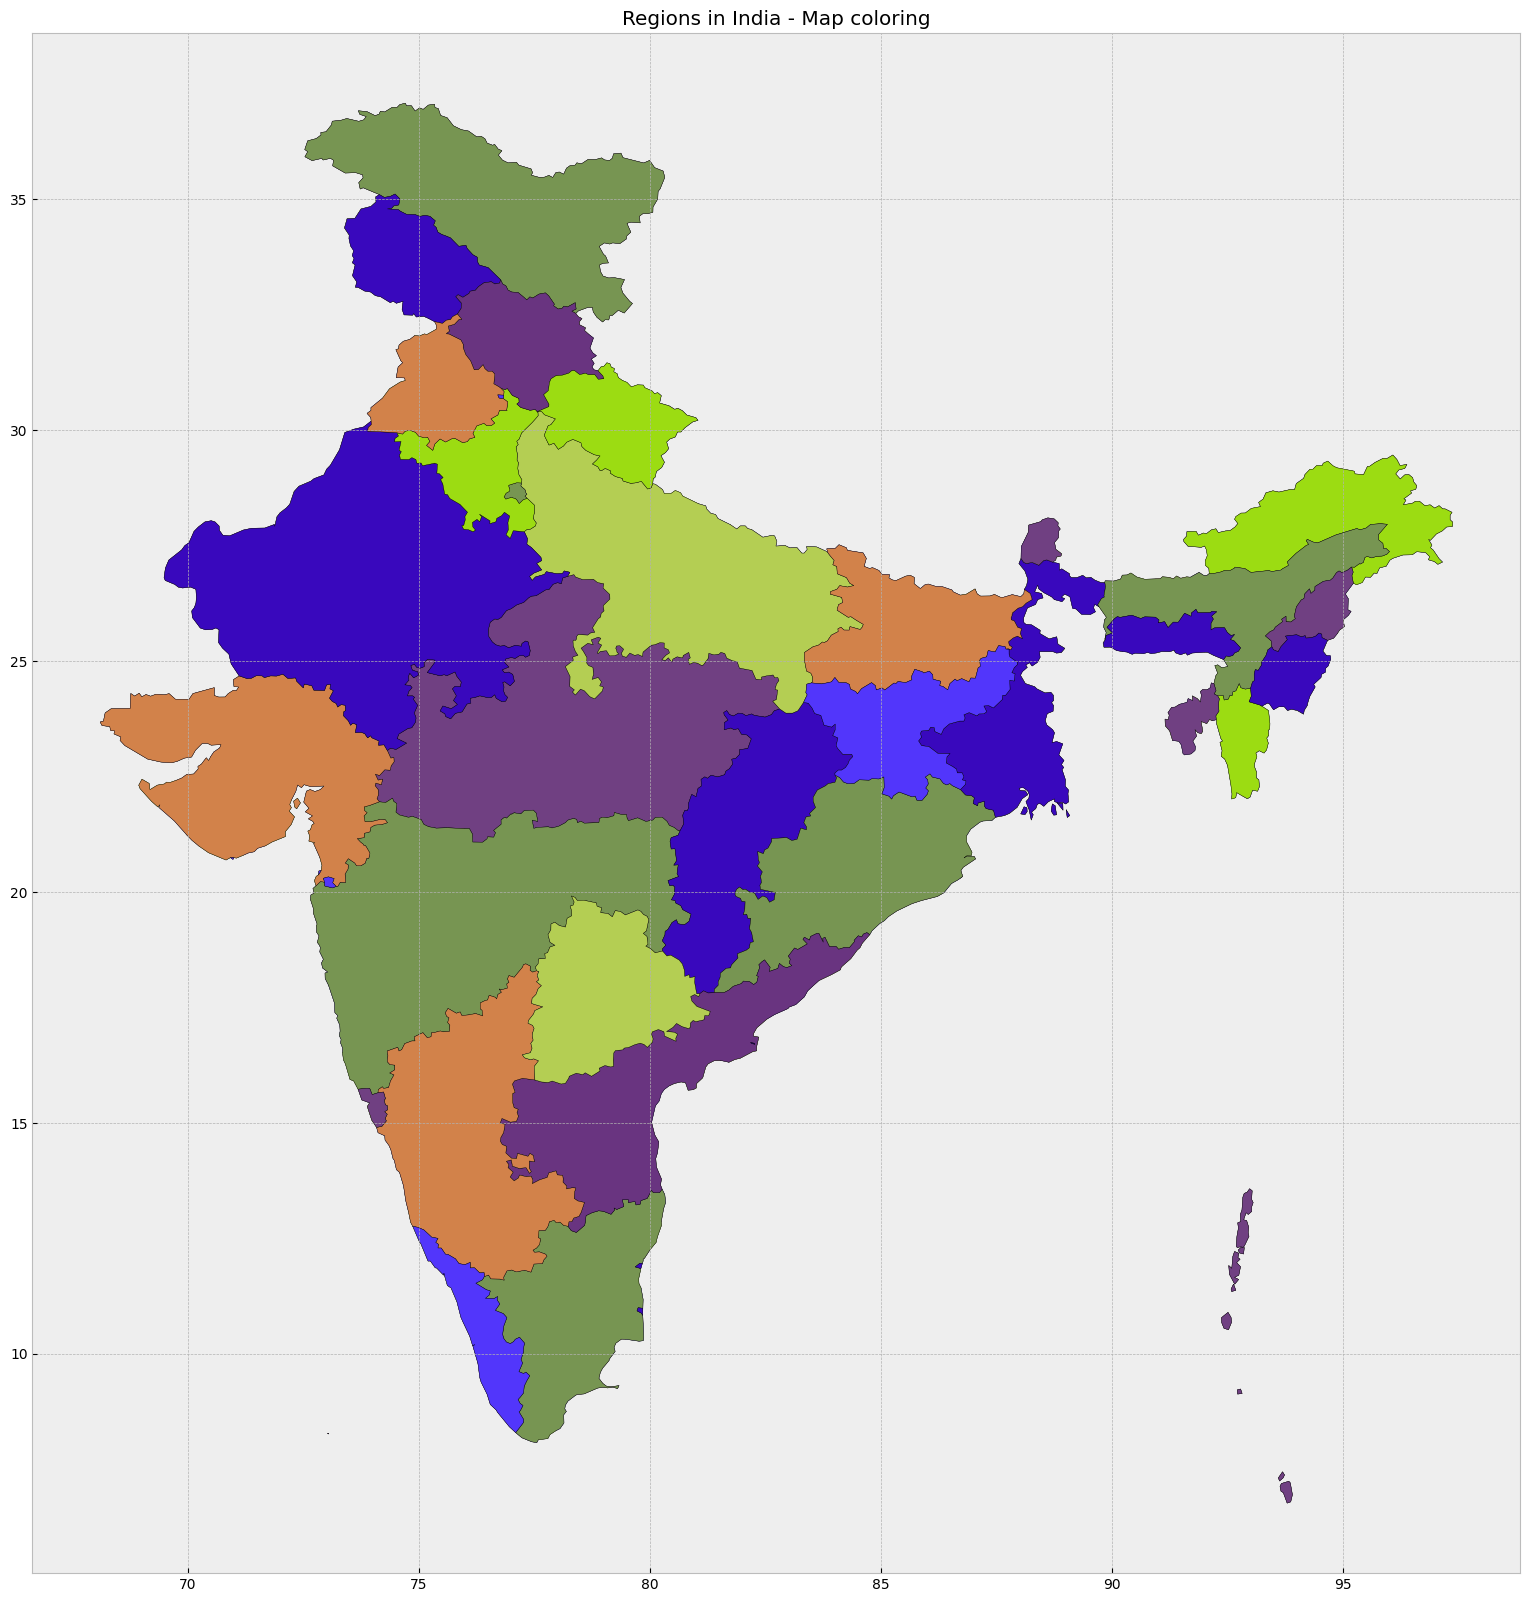

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
plt.style.use('bmh')

# Generate 50 unique colors (adjust based on the number of regions)
num_colors = len(india_region_gdf["color"].unique())
custom_cmap = mcolors.ListedColormap(np.random.rand(num_colors, 3))  # Random RGB colors

# Plot Regions map
india_region_gdf.plot(
    ax=ax, 
    column="color",  # Assign unique colors
    cmap=custom_cmap,  
    edgecolor='black',
    linewidth=0.25,
    categorical=True
)

plt.title("Regions in India - Map coloring")
plt.show()


# Conclusions

We applied an adjacency graph approach to colorize a map with the constraint to not have adjacent polygons collored with the same color.

# Acknowledgement:

[https://www.kaggle.com/code/gpreda/china-regions-map-coloring-with-geopandas/notebook](http://)